In [3]:
import numpy as np
import yaml
import torch
import torch.nn as nn
import torch.nn.functional as F

from competence_estimation.utils import load_data, get_network_weights, mix_open
from competence_estimation.scores  import create_score_function
from competence_estimation.metrics  import compute_metric

import pandas as pd
import matplotlib.pyplot as plt

# Short Introduction

The following files are required:
* {x}_id_train.npy
* {x}_id_val.npy
* {x}_id_test.npy
where x = features, logits, labels

and the same for ood samples:
* {x}_ood
where x = features, logits, labels

Additionally we require the weights w and biases b of the last layer

# Data and Config Loading

In [4]:
with open("config.yml", "r") as file:
    config = yaml.safe_load(file)

# Create Plot

In [7]:
# Here you have to include your own path
# dataset_path = "/home/DATA/ITWM/lorenzp/"
dataset_path = "/home/lorenzp/workspace/competence_estimation/features/cifar10"
# algorithm = "ERM"
model = "resnet18"

load_data = model

w = np.load(f"{dataset_path}/spatial/{model}_W.npy")
b = np.load(f"{dataset_path}/spatial/{model}_b.npy")

# Features/logits/labels Trainings data
features_id_train =  np.load(f"{dataset_path}/spatial/features_{model}_train.npy")[:30000]
logits_id_train = np.load(f"{dataset_path}/spatial/logits_{model}_train.npy")[:30000]
labels_id_train =  np.load(f"{dataset_path}/spatial/labels_{model}_train.npy")[:30000]

# Features/logits/labels Validation data
features_id_val = np.load(f"{dataset_path}/spatial/features_{model}_train.npy")[30000:]
logits_id_val = np.load(f"{dataset_path}/spatial/logits_{model}_train.npy")[30000:]
labels_id_val = np.load(f"{dataset_path}/spatial/labels_{model}_train.npy")[30000:]

# Features/logits/labels Test data
features_id_test = np.load(f"{dataset_path}/spatial/features_{model}_test.npy")[:5000]
logits_id_test = np.load(f"{dataset_path}/spatial/logits_{model}_test.npy")[:5000]
labels_id_test = np.load(f"{dataset_path}/spatial/labels_{model}_test.npy")[:5000]


print(
    features_id_train.shape,
    features_id_val.shape,
    features_id_test.shape
)

metrics = ['quantiles']
results = {}
results_frac = {}
attacks = ['nor', 'fgsm', 'linfpgd', 'linfdf', 'l2df']
# attacks = ['nor', 'fgsm']
score_fct = ["max_softmax", "max_logit", "vim", "mahalanobis", "knn", "energy", "energy_react", "GMM",  "PCA"]
# score_fct = ["max_softmax", "max_logit", "vim"]

# attacks = ['pgd']
# score_fct = [ "vim" ]


for it, attack in enumerate(attacks):
    print("attack: ", attack)
    results[attack] = {}
    results_frac[attack] = {}
    
    if it == 0:
        features_ood = np.load(f"{dataset_path}/features_{model}_test.npy")[5000:]
        logits_ood = np.load(f"{dataset_path}/logits_{model}_test.npy")[5000:]
        labels_ood = np.load(f"{dataset_path}/labels_{model}_test.npy")[5000:]
    else:
        features_ood = np.squeeze(np.load(f"{dataset_path}/features_{attack}_{load_data}_test.npy"))[5000:]
        logits_ood = np.load(f"{dataset_path}/logits_{attack}_{load_data}_test.npy")[5000:]
        labels_ood = np.load(f"{dataset_path}/labels_{attack}_{load_data}_test.npy")[5000:]
    
    scores_ood_test = score_function(features_ood, logits_ood)
    
    for it2, score_function_name in enumerate(score_fct):
        scores_id_val, score_function = create_score_function(
            features_id_train,
            logits_id_train,
            labels_id_train,
            features_id_val,
            logits_id_val,
            labels_id_val,
            w,
            b,
            score_function =  score_function_name,
            **config
        )
        scores_id_train = score_function(features_id_train, logits_id_train)
        scores_id_test  = score_function(features_id_test, logits_id_test)
        
        print(features_id_train.shape)
                                         
        outs = compute_metric(
            scores_id_val,
            scores_id_test,
            scores_ood_test,
            features_id_train,
            logits_id_train,
            labels_id_train,
            features_id_test,
            logits_id_test,
            labels_id_test,
            features_ood,
            logits_ood,
            labels_ood,
            metrics=metrics
        )

        print(score_function_name, outs)
        results[attack][score_function_name] = outs['n_95']
        results_frac[attack][score_function_name] = outs['n_95_frac']
        
keys = list(results.keys())
methods  = list(results[keys[0]].keys())
        
table = {}
table_frac = {}

for method in methods: 
    table[method] = []
    table_frac[method] = []
    
    for  key in keys:
        table[method].append(results[key][method])
        table_frac[method].append(results_frac[key][method])

(30000, 512) (20000, 512) (5000, 512)
attack:  nor
(30000, 512)
max_softmax {'n_95_frac': 0.9562, 'n_95': 0.200376495718956}
(30000, 512)
max_logit {'n_95_frac': 0.0, 'n_95': nan}
(30000, 512)
vim {'n_95_frac': 1.0, 'n_95': 0.19619999825954437}
(30000, 512)
mahalanobis {'n_95_frac': 1.0, 'n_95': 0.19619999825954437}
(30000, 512)
knn {'n_95_frac': 1.0, 'n_95': 0.19619999825954437}
(30000, 512)
energy {'n_95_frac': 0.0, 'n_95': nan}
(30000, 512)
energy_react {'n_95_frac': 0.0, 'n_95': nan}
(30000, 512)
GMM {'n_95_frac': 0.0, 'n_95': nan}
(30000, 512)
PCA {'n_95_frac': 1.0, 'n_95': 0.19619999825954437}
attack:  fgsm
(30000, 512)
max_softmax {'n_95_frac': 0.0, 'n_95': nan}
(30000, 512)
max_logit {'n_95_frac': 0.0, 'n_95': nan}
(30000, 512)
vim {'n_95_frac': 1.0, 'n_95': 0.2572000026702881}
(30000, 512)
mahalanobis {'n_95_frac': 1.0, 'n_95': 0.2572000026702881}
(30000, 512)
knn {'n_95_frac': 0.841, 'n_95': 0.27776455879211426}
(30000, 512)
energy {'n_95_frac': 0.0, 'n_95': nan}
(30000, 512)

In [8]:
methods

['max_softmax',
 'max_logit',
 'vim',
 'mahalanobis',
 'knn',
 'energy',
 'energy_react',
 'GMM',
 'PCA']

In [9]:
keys

['nor', 'fgsm', 'linfpgd', 'linfdf', 'l2df']

In [10]:
table.keys()

dict_keys(['max_softmax', 'max_logit', 'vim', 'mahalanobis', 'knn', 'energy', 'energy_react', 'GMM', 'PCA'])

In [11]:
results['nor']

{'max_softmax': 0.200376495718956,
 'max_logit': nan,
 'vim': 0.19619999825954437,
 'mahalanobis': 0.19619999825954437,
 'knn': 0.19619999825954437,
 'energy': nan,
 'energy_react': nan,
 'GMM': nan,
 'PCA': 0.19619999825954437}

In [12]:
results['fgsm']

{'max_softmax': nan,
 'max_logit': nan,
 'vim': 0.2572000026702881,
 'mahalanobis': 0.2572000026702881,
 'knn': 0.27776455879211426,
 'energy': nan,
 'energy_react': nan,
 'GMM': nan,
 'PCA': 0.3333333432674408}

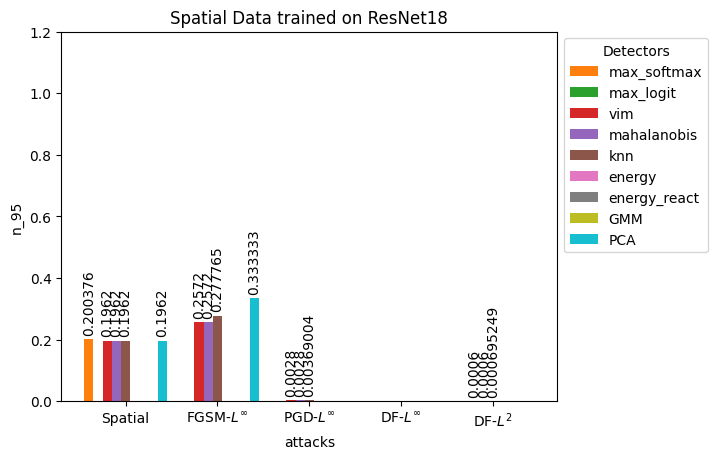

In [15]:
color=["#ff7f0e", "#2ca02c", '#d62728', '#9467bd', "#8c564b", "#e377c2", '#7f7f7f', '#bcbd22', '#17becf'][:len(table)]

raw_data = {
     'plan_type':  ['Spatial', 'FGSM-$L^\infty$', 'PGD-$L^\infty$', 'DF-$L^\infty$', 'DF-$L^2$'][:len(keys)],
}

for method in methods:
    raw_data[ method] = table[method]

df = pd.DataFrame(raw_data, columns=methods)
ax = df.plot.bar(rot=0, color=color[:len(table)], width=0.9)

for p in ax.patches[0:]:
    h = p.get_height()
    x = p.get_x()+p.get_width()/2.
    if h != 0:
        ax.annotate("%g" % p.get_height(), xy=(x, h), xytext=(0, 3), rotation=90, 
                   textcoords="offset points", ha="center", va="bottom")

plt.title("Spatial Data trained on ResNet18")
      
ax.set_ylim(0, 1.2)
ax.legend(title="Detectors", bbox_to_anchor=(1.0, 1), loc='upper left')
ax.set_xticklabels(raw_data["plan_type"])
plt.xlabel("attacks")
plt.ylabel("n_95")

plt.savefig("plots/spatial_95.png", bbox_inches='tight', dpi=300)

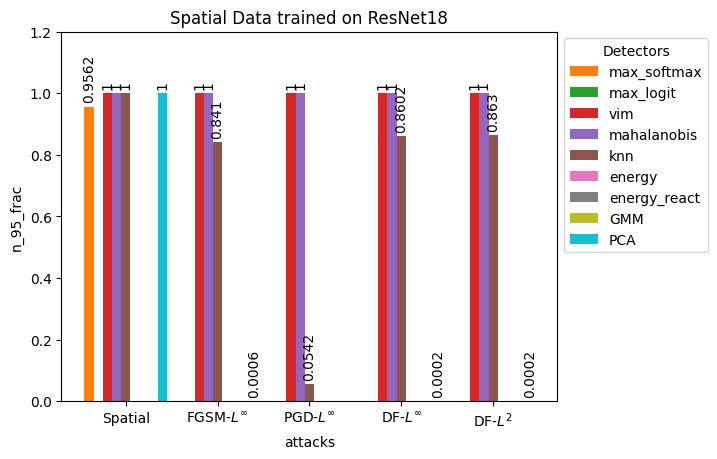

In [19]:
color=["#ff7f0e", "#2ca02c", '#d62728', '#9467bd', "#8c564b", "#e377c2", '#7f7f7f', '#bcbd22', '#17becf'][:len(table)]

raw_data = {
     'plan_type':  ['Spatial', 'FGSM-$L^\infty$', 'PGD-$L^\infty$', 'DF-$L^\infty$', 'DF-$L^2$'][:len(keys)],
}

for method in methods:
    raw_data[method] = table_frac[method]

df = pd.DataFrame(raw_data, columns=methods)
ax = df.plot.bar(rot=0, color=color[:len(table)], width=0.9)

for p in ax.patches[0:]:
    h = p.get_height()
    x = p.get_x()+p.get_width()/2.
    if h != 0:
        ax.annotate("%g" % p.get_height(), xy=(x, h), xytext=(0, 3), rotation=90, 
                   textcoords="offset points", ha="center", va="bottom")

plt.title("Spatial Data trained on ResNet18")
      
ax.set_ylim(0, 1.2)
ax.legend(title="Detectors", bbox_to_anchor=(1.0, 1), loc='upper left')
ax.set_xticklabels(raw_data["plan_type"])
plt.xlabel("attacks")
plt.ylabel("n_95_frac")

plt.savefig("plots/spatial_95_frac.png", bbox_inches='tight', dpi=300)